<h1>Importing Liabraries and Dataset</h1>

In [1]:
!pip install mtcnn
!pip install keras-video-generators
import os
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import os
import glob
import keras
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import seaborn as sns
import gc
from tensorflow.keras.models import Sequential
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.layers import Conv2D, BatchNormalization,MaxPooling2D, GlobalMaxPool2D,Dense, Dropout,Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

     |████████████████████████████████| 2.3 MB 5.2 MB/s 
  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-py3-none-any.whl size=12882 sha256=1d400ae088268a096ec3bfe4170fb8189816859cb5080f9cc36bdf7bc3f0e965
  Stored in directory: /root/.cache/pip/wheels/bc/22/94/eda4e8caf00c0ffd3030fecbf2e0334b8a7f038f4451e20b00
Successfully built keras-video-generators


In [2]:
path = '/content/drive'
drive.mount(path)

Mounted at /content/drive


<h3>Note : If you already have done preprocessing please skip to Data Augmentation</h3>

In [3]:
'''add path to your dataset, the dataset must contain two subdirectories consisting of the classes
in the classes function add the name of your subdirectory'''

train_path ='/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Implementation)/'

classes = ["Fake","Real"]

video_files = []
labels = []

for i in classes:
  temp_path = train_path + i +'/'

  for files in os.listdir(temp_path):
    path = temp_path + files
    video_files.append(path)
    labels.append(i)

<h1>Preprocessing Dataset</h1>

In [ ]:
try:
    os.mkdir('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Implementation)/')
    os.mkdir('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Implementation)/Real')
    os.mkdir('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Implementation)/Fake')
except:
    print('Dir already exists')
    
path_fake = '/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Implementation)/Fake/'
path_real = '/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Implementation)/Real/'

In [ ]:
'''Currently the image frames in a video are of different shape so using crop_frames we will 
extract the frames from the videos and using face recognition we will detect face in the frames
and then crop the image having only face. Later we will resize the cropped images to (256,256) '''

'''The dataset used is already preprocessed and resized and hence we don't need to run the function again'''

def crop_frames(image,label,k):
    
    faces = detector.detect_faces(image)
    p= 60
    
    if(len(faces)>0):
        for face in faces:

            x, y, width, height = face['box']
            x = x - min(x,60)
            x1 = x+width+ min(image.shape[1]-x-width,60)
            y = y - min(y,60)
            y1 = y+height+ min(image.shape[0]-y-height,60)
            crop = np.array(image[y:y1,x:x1])
            crop = cv.cvtColor(crop,cv.COLOR_BGR2RGB)
            k = k+1

            if label == 'FAKE':
                cv.imwrite(path_fake+str(k)+'.jpeg',crop)
            else:
                cv.imwrite(path_real+str(k)+'.jpeg',crop)

    return k

In [ ]:
#main code which will call the function for cropping the videos

detector = MTCNN()

frame = np.arange(5,101,5)
k = 0

for i in range(len(X)):
    cnt = 0
    cap = cv.VideoCapture(X[i])
    while(cnt<101):
        _,image = cap.read()
        
        if cnt in frame:
            k = crop_frames(image,Y[i],k)
            
        cnt= cnt+1

    cap.release()
    print(i)

<h1>Data Augmentation</h1>

In [3]:
# since we have fewer data we will use data augmentation techniques to boost out accuracy
# set the input path to the directory consisting the training folder

input_path = '/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Implementation)/'

# datagen is ImageDataGenerator variable which will be used to augment our data

datagen = ImageDataGenerator(rescale=1/255,
                             rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=0.1,
                             width_shift_range=0.1,
                             shear_range=0.1,
                             validation_split=0.2
                            )

train_gen= datagen.flow_from_directory(input_path,
                                       target_size=(256,256),
                                       class_mode='binary',
                                       subset='training'
                                      )
val_gen = datagen.flow_from_directory( input_path,
                                       target_size=(256,256),
                                       class_mode='binary',
                                       subset='validation'
                                      )

Found 1331 images belonging to 2 classes.
Found 332 images belonging to 2 classes.


In [4]:
# we will use Meso-4 network Architecture

model = Sequential()
model.add(Conv2D(8,(3,3),activation='relu',padding='same',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(8,(5,5),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16,(5,5),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16,(5,5),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((4,4)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [5]:
model.summary() # print the model architecture

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       1608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        3

In [6]:
# we will use binary crossentropy as our loss function and adam as the optimizer
# we will set our metrics to accuracy so that we can observe model accuracy during training
# the model will train for 50 epochs

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history = model.fit(train_gen,validation_data=val_gen, epochs=50)

Epoch 1/50
42/42 [==============================] - 504s 11s/step - loss: 0.9793 - accuracy: 0.5252 - val_loss: 0.7019 - val_accuracy: 0.5030
Epoch 2/50
42/42 [==============================] - 27s 656ms/step - loss: 0.6933 - accuracy: 0.5530 - val_loss: 0.7302 - val_accuracy: 0.4910
Epoch 3/50
42/42 [==============================] - 27s 654ms/step - loss: 0.6815 - accuracy: 0.5718 - val_loss: 0.7200 - val_accuracy: 0.4428
Epoch 4/50
42/42 [==============================] - 27s 645ms/step - loss: 0.6730 - accuracy: 0.5687 - val_loss: 0.6997 - val_accuracy: 0.5361
Epoch 5/50
42/42 [==============================] - 27s 653ms/step - loss: 0.6508 - accuracy: 0.5965 - val_loss: 0.7197 - val_accuracy: 0.4880
Epoch 6/50
42/42 [==============================] - 27s 647ms/step - loss: 0.6830 - accuracy: 0.5259 - val_loss: 0.6856 - val_accuracy: 0.6235
Epoch 7/50
42/42 [==============================] - 27s 650ms/step - loss: 0.6655 - accuracy: 0.5770 - val_loss: 0.6838 - val_accuracy: 0.5753


<h1>'>Graphs and Saving model</h1>

In [7]:
#this custom graph can plot graph for loss as well for accuracy
def plot_graph(history,string):
    
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.grid()
    plt.title(string+' vs epochs')
    plt.savefig('./'+string+'.png')
    plt.show()

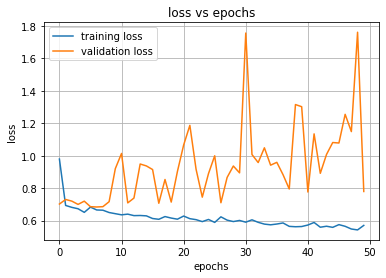

In [8]:
plot_graph(history,'loss')

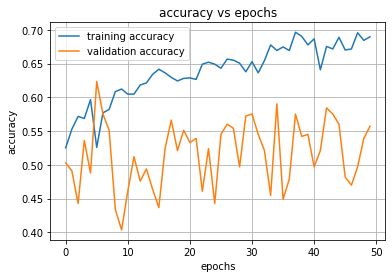

In [9]:
plot_graph(history,'accuracy')

In [11]:
try:
  os.mkdir('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/weights(implementation)')

except:
  print('Directory already exists')
  
model.save('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/weights(implementation)/weights')

Directory already exists
INFO:tensorflow:Assets written to: /content/drive/MyDrive/deepfake_detection/DeepFake_Detection/weights(implementation)/weights/assets


<h1>Prediction</h1>

In [24]:
#loading the saved model

keras.models.load_model('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/weights(implementation)/weights')

In [20]:
#Model predict 0 for fake images and 1 for real images

def predictor(image):
    
    faces = detector.detect_faces(image)
    p= 60
    cat = 0
    
    if(len(faces)>0):
        for face in faces:

            x, y, width, height = face['box']
            x = x - min(x,60)
            x1 = x+width+ min(image.shape[1]-x-width,60)
            y = y - min(y,60)
            y1 = y+height+ min(image.shape[0]-y-height,60)
            crop = np.array(image[y:y1,x:x1])
            crop = cv.resize(crop,(256,256))
            crop = crop.reshape(-1,256,256,3)
            q = model.predict(crop)
            
            if q < 0.5:
                cat=0
            else:
                cat=1

    return cat

In [23]:
# set the path to the video you want to test 

detector = MTCNN()
images_list = []
output = []
path  = '/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Upgradation)/Fake/aaagqkcdis.mp4'
frame = np.arange(5,150,5)

for _ in range(1):
    cnt = 0
    cap = cv.VideoCapture(path)
    
    while(cnt<151):
        _,image = cap.read()
        
        if cnt in frame:
             output.append(predictor(image))
            
        cnt= cnt+1

    cap.release()

if len(cat)%2==0:
  cat = cat[:-1]

k = max(set(cat), key = cat.count)

if k==0:
  print('Video is forged')

else:
  print('Video is real')


Video is forged
